In [1]:
import sys 
sys.executable

'C:\\Users\\Changho_Notebook\\anaconda3\\python.exe'

In [64]:
import pandas as pd 
import numpy as np 
%matplotlib inline
import matplotlib.pyplot as plt
import re 
import urllib.request
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# XGBoost
import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBClassifier

In [5]:
data = pd.read_csv('./data/test_data0415.csv', encoding = 'euc-kr')

In [6]:
data

,Text,Feeling,Talking,book_id,sentence_id,Feeling_Saltlux
0,"‘인도’가 적에게 포위를 당했는데, 적들이 은화 6백 개를 내놓을 때까지 물러나지 ...",2.0,0,5001,1,분노
1,"그래서 주민들이 북을 치며 선포하길,",2.0,0,5001,2,공포
2,*누구든 그 돈을 마련하는 사람을 시장으로 삼겠다*,2.0,1,5001,3,기대
3,라고 했답니다,0.0,0,5001,4,신뢰
4,"때마침 가난한 어부가 자신의 아들과 호수에서 물고기를 잡아 생활하다, 그 적들이 들...",5.0,0,5001,5,혐오
...,...,...,...,...,...,...
12372,그런데 그 호랑이는 바로 옛날에 나무꾼이 도와주었던 호랑이였습니다,4.0,0,7009,30,신뢰
12373,*저는 나이가 들어 어차피 죽을 목숨이니 저를 임금에게 제물로 바치십시오*,4.0,1,7009,31,분노
12374,그러곤 호랑이는 숨을 거두었습니다,4.0,0,7009,32,신뢰
12375,나무꾼은 숨을 거둔 호랑이를 차마 제물로 바치지 못하고 양지바른 땅에 묻어주었습니다,4.0,0,7009,33,혐오


In [7]:
print(len(data))

12377


In [8]:
data = data.iloc[:,:2]

In [9]:
data

,Text,Feeling
0,"‘인도’가 적에게 포위를 당했는데, 적들이 은화 6백 개를 내놓을 때까지 물러나지 ...",2.0
1,"그래서 주민들이 북을 치며 선포하길,",2.0
2,*누구든 그 돈을 마련하는 사람을 시장으로 삼겠다*,2.0
3,라고 했답니다,0.0
4,"때마침 가난한 어부가 자신의 아들과 호수에서 물고기를 잡아 생활하다, 그 적들이 들...",5.0
...,...,...
12372,그런데 그 호랑이는 바로 옛날에 나무꾼이 도와주었던 호랑이였습니다,4.0
12373,*저는 나이가 들어 어차피 죽을 목숨이니 저를 임금에게 제물로 바치십시오*,4.0
12374,그러곤 호랑이는 숨을 거두었습니다,4.0
12375,나무꾼은 숨을 거둔 호랑이를 차마 제물로 바치지 못하고 양지바른 땅에 묻어주었습니다,4.0


In [11]:
data['Text'].nunique(), data['Feeling'].nunique()

(11739, 6)

In [12]:
display(data[data.duplicated()])

,Text,Feeling
54,라고 말했어요,0.0
172,"*젬지 산아, 젬지 산아, 열리거라*",2.0
215,라고 그가 말했어요,0.0
316,라며 당나귀가 말했어요,0.0
325,라며 그가 말했어요,0.0
...,...,...
11941,라며 여왕폐하가 말했어요,0.0
11949,라며 앨리스가 말했지요,0.0
11950,*저 애의 목을 쳐라*,3.0
11953,라며 앨리스가 말했어요,0.0


In [14]:
data['Feeling'].value_counts()

5.0    4836
2.0    3255
0.0    2362
1.0     896
3.0     524
4.0     499
Name: Feeling, dtype: int64

In [15]:
data = data[data["Feeling"] != 22.0]

In [16]:
data['Feeling'].value_counts()

5.0    4836
2.0    3255
0.0    2362
1.0     896
3.0     524
4.0     499
Name: Feeling, dtype: int64

<AxesSubplot:>

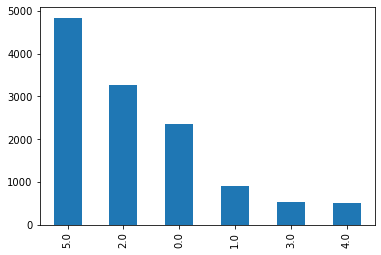

In [17]:
data['Feeling'].value_counts().plot(kind='bar')

In [18]:
#  결측치 제거

In [19]:
data.isnull().sum()

Text       0
Feeling    5
dtype: int64

In [20]:
data = data.dropna(how = 'any')
print(data.isnull().values.any())

False


In [21]:
data = data.astype({"Feeling" : 'int64'})
data['Feeling']

0        2
1        2
2        2
3        0
4        5
        ..
12372    4
12373    4
12374    4
12375    4
12376    4
Name: Feeling, Length: 12372, dtype: int64

In [22]:
# 한글만 남기기 

data['Text'] = data['Text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
data

,Text,Feeling
0,인도가 적에게 포위를 당했는데 적들이 은화 백 개를 내놓을 때까지 물러나지 않겠다고...,2
1,그래서 주민들이 북을 치며 선포하길,2
2,누구든 그 돈을 마련하는 사람을 시장으로 삼겠다,2
3,라고 했답니다,0
4,때마침 가난한 어부가 자신의 아들과 호수에서 물고기를 잡아 생활하다 그 적들이 들이...,5
...,...,...
12372,그런데 그 호랑이는 바로 옛날에 나무꾼이 도와주었던 호랑이였습니다,4
12373,저는 나이가 들어 어차피 죽을 목숨이니 저를 임금에게 제물로 바치십시오,4
12374,그러곤 호랑이는 숨을 거두었습니다,4
12375,나무꾼은 숨을 거둔 호랑이를 차마 제물로 바치지 못하고 양지바른 땅에 묻어주었습니다,4


In [1]:
X_train, y_train = train_test_split(data['Text'], 
                                                                                                        test_size=0.25, 
                                                    random_state=1004)

NameError: name 'train_test_split' is not defined

In [26]:
print(X_train)
print(X_test)
print(y_train)
print(y_test)

1198         그러다 하인이 탄 말의 다리가 부러지는 바람에 그는 더는 저를 쫓아올 수 없었지요
2906      하지만 늑대는 그들 모두를 찾아내선 다짜고짜 한 명씩 차례로 꿀꺽 꿀꺽 집어 삼켜버렸다
6684     소 주인인 농부는 그 말 새끼가 자신의 소들 중 한 마리가 낳은 거니 자기가 데려가...
3476                                         자자 어서 마차를 끌어봐
4222                                          당신은 죽어야하오 부인
                               ...                        
8211              그녀는 점점 더 날쌔지는데 반해 젊은이의 짐은 점점 더 무거워져만 갔지요
8396     저기 그녀가 오는데 이제 마녀들 중 한 명을 찾았으니 다른 마녀도 금방 찾을 수 있겠는걸
9460          왜냐면 그녀의 머리카락은 아주 긴 곱슬머리지만 지금의 난 전혀 곱슬머리가 아닌걸
4129      왕자님은 그녀가 기절할 정도로 예쁜 것을 보고 왜 거기 혼자 숨어서 울고 있는지를...
10768    참 별나다란 생각이 들어 앨리스가 자세히 보려고 다가가 보았더니 그들 중 한 명이 ...
Name: Text, Length: 9279, dtype: object
5721              너무도 목이 말랐기에 공주가 말에서 내려 시내물 위로 몸을 숙여 마셨어요
3508      아침 일찍 날이 밝아올 무렵 그러니까 모두가 아직 잠들어 있을 때 수탉이 암탉을 ...
4402                의심할 여지도 없이 왕자는 이 희한한 모험을 자신이 종결시키고 싶었다
7917                                     네 수명을 년으로 하기로 했단다
10638                                   전 아는 얘기거리가 하나도 없어요
                

In [27]:
# 토큰화

In [28]:
# 추후 늘리기
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [29]:
okt = Okt()
X_trains = []
for sentence in X_train:
    temp_X = okt.morphs(sentence, stem = True) # 토큰화 
    temp_X = [word for word in temp_X if not word in stopwords]
    X_trains.append(temp_X)

In [30]:
# word_list = []
# for word in temp_X :
#    if not word in stopwords:
#        word_list.append(word)

In [31]:
okt = Okt()
X_tests = []
for sentence in X_test:
    temp_X = okt.morphs(sentence, stem = True) # 토큰화 
    temp_X = [word for word in temp_X if not word in stopwords]
    X_tests.append(temp_X)

In [32]:
X_train = X_trains
X_test = X_tests

In [33]:
print(X_train[:3])
print(X_test[:3])

[['그렇다', '하인', '타다', '말', '다리', '부러지다', '바람', '그', '더', '저', '쫓아오다', '수', '없다'], ['하지만', '늑대', '그', '모두', '찾아내다', '선', '다짜고짜', '명', '씩', '차례', '로', '꿀꺽', '꿀꺽', '집다', '삼키다', '버리다'], ['소', '주인', '인', '농부', '그', '말', '새끼', '자신', '소', '중', '마리', '낳다', '거니', '자기', '데려가다', '우기다', '상대방', '말', '낳다', '새끼', '라며', '그건', '자기', '거', '라고', '우기다']]
[['너무도', '목', '마르다', '공주', '말', '에서', '내다', '시내', '물', '위로', '몸', '을', '숙이다', '마시다'], ['아침', '일찍', '날', '밝다', '오다', '무렵', '그러니까', '모두', '아직', '잠들다', '있다', '때', '수탉', '암탉', '을', '깨우다', '어제', '그', '계란', '을', '가져오다', '부리', '로', '쪼', '아', '깨다', '다음', '함께', '나누다', '먹고다', '계란', '껍질', '을', '난로', '위', '던지다'], ['의심', '여지', '없이', '왕자', '희한하다', '모험', '을', '자신', '종결', '시키다', '싶다']]


In [34]:
# 정수 인코딩
tokenizer = Tokenizer() 
tokenizer.fit_on_texts(X_train)

In [35]:
print(tokenizer.word_index)

{'을': 1, '그': 2, '말': 3, '있다': 4, '그녀': 5, '라며': 6, '그렇다': 7, '로': 8, '보다': 9, '않다': 10, '에게': 11, '없다': 12, '자신': 13, '이다': 14, '에서': 15, '가다': 16, '거': 17, '내': 18, '게': 19, '왕': 20, '수': 21, '되다': 22, '하지만': 23, '들다': 24, '것': 25, '고': 26, '다': 27, '앨리스': 28, '더': 29, '네': 30, '요': 31, '두': 32, '저': 33, '그래서': 34, '다음': 35, '다시': 36, '때': 37, '말다': 38, '안': 39, '하나': 40, '오다': 41, '되어다': 42, '못': 43, '생각': 44, '사람': 45, '아니다': 46, '님': 47, '제': 48, '걸': 49, '만': 50, '집': 51, '라고': 52, '예요': 53, '먹다': 54, '공주': 55, '왕자': 56, '뭐': 57, '아이': 58, '크다': 59, '소리': 60, '당신': 61, '까지': 62, '날': 63, '엔': 64, '해주다': 65, '시작': 66, '아내': 67, '하고': 68, '눈': 69, '아': 70, '같다': 71, '나': 72, '아빠': 73, '모두': 74, '속': 75, '자다': 76, '버리다': 77, '왕비': 78, '이제': 79, '지': 80, '정말': 81, '앉다': 82, '좋다': 83, '번': 84, '엄마': 85, '주다': 86, '그리고': 87, '세': 88, '일': 89, '손': 90, '어떻다': 91, '받다': 92, '알다': 93, '들어가다': 94, '야': 95, '대답': 96, '위': 97, '모든': 98, '나무': 99, '우리': 100, '난': 101, '전': 102, '나오다': 103, '숲

In [36]:
threshold = 4
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0   # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0  # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 7225
등장 빈도가 3번 이하인 희귀 단어의 수: 4318
단어 집합에서 희귀 단어의 비율: 59.76470588235294
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 7.160653615919754


In [37]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 2908


In [38]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [39]:
print(X_train[:3])

[[7, 200, 758, 3, 287, 1342, 154, 2, 29, 33, 21, 12], [23, 238, 2, 74, 1945, 171, 1946, 152, 288, 1075, 8, 1000, 1000, 334, 824, 77], [480, 190, 111, 349, 2, 3, 197, 13, 480, 230, 116, 699, 632, 142, 785, 2179, 1738, 3, 699, 197, 6, 176, 142, 17, 52, 2179]]


In [40]:
# 빈 샘플 제거 
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
drop_train2 = [index for index, sentence in enumerate(X_test) if len(sentence) < 1]

In [41]:
print(len(X_train))
y_train = list(y_train)
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

9279
9242
9242


C:\Users\Changho_Notebook\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [42]:
y_test = list(y_test)
X_test = np.delete(X_test, drop_train2, axis=0)
y_test = np.delete(y_test, drop_train2, axis=0)
print(len(X_test))
print(len(y_test))

3070
3070


리뷰의 최대 길이 : 66
리뷰의 평균 길이 : 9.31356849166847


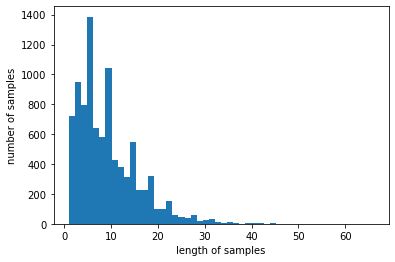

In [43]:
# 패딩
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [44]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [45]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 98.88552261415278


In [46]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [47]:
# y(결과값) 라벨링
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [48]:
# 모델 시작 (LSTM)

In [49]:
from tensorflow.keras.layers import Embedding, Dense, LSTM, GRU, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [52]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(Bidirectional(LSTM(256)))
# model.add(Dense(256, activation = 'relu'))
model.add(Dense(6,activation = 'softmax'))

In [53]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4)
mc = ModelCheckpoint('best_model.h5', monitor = 'val_acc', mode = 'max', verbose = 1, save_best_only = True)

In [56]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)
# history = model.fit(X_train, y_train, epochs=15, callbacks=[mc], batch_size=60, validation_split=0.2)

Epoch 1/15
124/124 [==============================] - 8s 23ms/step - loss: 0.5549 - acc: 0.7987 - val_loss: 1.6724 - val_acc: 0.4819

Epoch 00001: val_acc did not improve from 0.50135
Epoch 2/15
124/124 [==============================] - 2s 15ms/step - loss: 0.4907 - acc: 0.8281 - val_loss: 1.9216 - val_acc: 0.4651

Epoch 00002: val_acc did not improve from 0.50135
Epoch 3/15
124/124 [==============================] - 2s 12ms/step - loss: 0.4283 - acc: 0.8508 - val_loss: 2.1106 - val_acc: 0.4586

Epoch 00003: val_acc did not improve from 0.50135
Epoch 4/15
124/124 [==============================] - 2s 13ms/step - loss: 0.3561 - acc: 0.8756 - val_loss: 2.3055 - val_acc: 0.4570

Epoch 00004: val_acc did not improve from 0.50135
Epoch 5/15
124/124 [==============================] - 2s 13ms/step - loss: 0.3027 - acc: 0.8968 - val_loss: 2.4295 - val_acc: 0.4581

Epoch 00005: val_acc did not improve from 0.50135
Epoch 00005: early stopping


- LSTM 256
    - adam -> 0.4939
    - rmsprop -> 0.4311
- LSTM 512 
    - adam -> 0.4500 큰차이 없음 
- GRU 256 
    - adam -> 0.49215
    - rmsprop -> 0.4180
- GRU 512 
    - adam -> 0.49825
- BiLSTM
    - adam -> 0.49651

In [57]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

96/96 [==============================] - 1s 5ms/step - loss: 1.3416 - acc: 0.4967

 테스트 정확도: 0.4967


In [58]:
def sentiment_predict(new_sentence):
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format(score))

In [60]:
# AUC 성능평가 확인

def metrics_evaluation(y_test, y_pred=None , y_pred_proba=None) :
    print("정확도 : {} , 정밀도 : {} , 재현율 : {} , 조화평균(F1) : {} , AUC : {} "
          .format(accuracy_score(y_test, y_pred) , 
                  precision_score(y_test, y_pred) , 
                  recall_score(y_test, y_pred) , 
                  f1_score(y_test, y_pred) , 
                  roc_auc_score(y_test, y_pred_proba) ) )

In [79]:
from sklearn.tree         import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble     import RandomForestClassifier

In [80]:
# 로지스틱 회귀로 학습,예측 및 평가 수행. 
lr_clf = LogisticRegression()
lr_clf.fit(X_train , y_train)
lr_y_pred = lr_clf.predict(X_test)

dt_clf =  DecisionTreeClassifier()
dt_clf.fit(X_train , y_train)
dt_y_pred = dt_clf.predict(X_test)

rf_clf =  RandomForestClassifier()
rf_clf.fit(X_train , y_train)
rf_y_pred = rf_clf.predict(X_test)

ValueError: y should be a 1d array, got an array of shape (9242, 6) instead.